### Cats And Dogs Classifier

In [29]:
# import necessary libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, sys, time

In [3]:
# read the data
data_path = "data/dogs_cats"
train_path = "data/dogs_cats/train"
validation_path = "data/dogs_cats/validation"

print("\033[4mTRAINING DATA\033[0m")
train_cats_names = os.listdir(os.path.join(train_path, "cats"))
train_dogs_names = os.listdir(os.path.join(train_path, "dogs"))

print("Cats: {}".format(len(train_cats_names)))
print("Dats: {}".format(len(train_dogs_names)))

cat_img = mpimg.imread(os.path.join(train_path, "cats", train_cats_names[0]))
dog_img = mpimg.imread(os.path.join(train_path, "dogs", train_dogs_names[0]))
print(f"Cat Image Shape: {cat_img.shape}")
print(f"Dog Image Shape: {dog_img.shape}")

## Validation Data
print("\033[4m\n\nTesting DATA\033[0m")
val_cats_names = os.listdir(os.path.join(validation_path, "cats"))
val_dogs_names = os.listdir(os.path.join(validation_path, "dogs"))

print("Cats: {}".format(len(val_cats_names)))
print("Dats: {}".format(len(val_dogs_names)))

cat_img = mpimg.imread(os.path.join(validation_path, "cats", val_cats_names[0]))
dog_img = mpimg.imread(os.path.join(validation_path, "dogs", val_dogs_names[0]))
print(f"Cat Image Shape: {cat_img.shape}")
print(f"Dog Image Shape: {dog_img.shape}")

TRAINING DATA
Cats: 1000
Dats: 1000
Cat Image Shape: (374, 500, 3)
Dog Image Shape: (500, 332, 3)


Testing DATA
Cats: 500
Dats: 500
Cat Image Shape: (499, 459, 3)
Dog Image Shape: (339, 200, 3)


In [4]:
# explore the data
pic_index = 0
# set the figure size where every image will occupies nrows*ncols inches.
def show_imgs(dir_path, cats_names, dogs_names, data_class="Train", fid=1, nrows=1, ncols=4):
    global pic_index
    plt.figure(fid)
    fig = plt.gcf()
    fig.set_size_inches(ncols*4, nrows*4)

    # get the (ncols*nrows)/2 horses names and (ncols*nrows)/2 human names.
    n = int((ncols*nrows)/2)
    pic_index += n
    cats = [ os.path.join(dir_path, "cats", c) 
             for c in cats_names[pic_index - n:pic_index] 
           ]

    dogs = [ os.path.join(dir_path, "dogs", d) 
             for d in dogs_names[pic_index-n:pic_index] 
           ]
    for img_i, img_path in enumerate(cats+dogs):
        sp = plt.subplot(1, 4, img_i + 1)
        sp.set_title(data_class)
        sp.axis('Off')
        img = mpimg.imread(img_path)
        plt.imshow(img)
    plt.show()


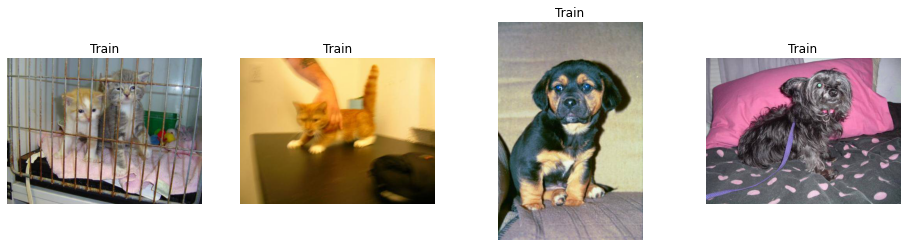

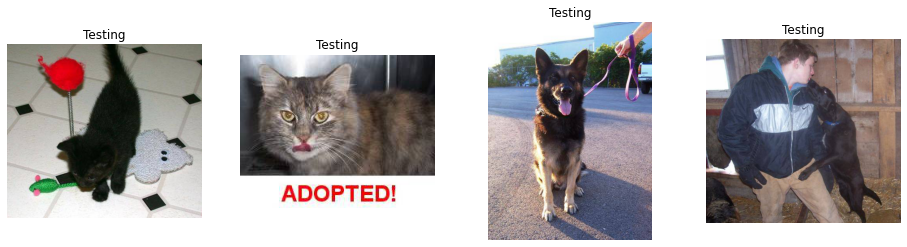

In [5]:
show_imgs(train_path, train_cats_names, train_dogs_names)
show_imgs(validation_path, val_cats_names, val_dogs_names, "Testing", 2)

In [19]:
# Some Constants
BATCH_SIZE = 20
TARGET_SIZE = (150, 150)
CLASS_MODE = 'binary'
EPOCHS = 10
WIDTH, HEIGHT, CHANNELS = cat_img.shape
TRAIN_DATA_SIZE = len(train_cats_names) + len(train_dogs_names)
VAL_DATA_SIZE = len(val_cats_names) + len(val_dogs_names)

In [13]:
# preprocess the data
# those operations will be done using the imageGenerator class 'normalization', `reshaping`, 'etc'
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_datagen       = ImageDataGenerator( rescale = 1.0/255. )
train_generator = train_datagen.flow_from_directory(train_path,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode=CLASS_MODE,
                                                    target_size=TARGET_SIZE)

# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )
validation_generator =  validation_datagen.flow_from_directory(validation_path,
                                                         batch_size  =BATCH_SIZE,
                                                         class_mode  = CLASS_MODE,
                                                         target_size = TARGET_SIZE)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
# define NN model

# define the model
model = keras.models.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(TARGET_SIZE + (CHANNELS,)) ),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [22]:
# compile and fit your model
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [25]:
# fit the model.
# define callBack to stop learning when accuracy reaches 70%
class AccCallBack(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.98):
          print(f"\nReached 98% accuracy so cancelling training in epoch{epoch}")
          self.model.stop_training = True
        pass



history = model.fit_generator(
    train_generator,
    steps_per_epoch=TRAIN_DATA_SIZE/BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=VAL_DATA_SIZE/BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[AccCallBack()],
    verbose=2)

Epoch 1/10
100/100 - 32s - loss: 0.5007 - accuracy: 0.7605 - val_loss: 0.5568 - val_accuracy: 0.7120
Epoch 2/10
100/100 - 37s - loss: 0.4186 - accuracy: 0.8140 - val_loss: 0.9636 - val_accuracy: 0.6730
Epoch 3/10
100/100 - 35s - loss: 0.3334 - accuracy: 0.8530 - val_loss: 0.6914 - val_accuracy: 0.7140
Epoch 4/10
100/100 - 35s - loss: 0.2608 - accuracy: 0.8905 - val_loss: 0.8032 - val_accuracy: 0.6970
Epoch 5/10
100/100 - 37s - loss: 0.1896 - accuracy: 0.9235 - val_loss: 0.9622 - val_accuracy: 0.7080
Epoch 6/10
100/100 - 36s - loss: 0.1407 - accuracy: 0.9495 - val_loss: 0.9326 - val_accuracy: 0.7260
Epoch 7/10
100/100 - 36s - loss: 0.1024 - accuracy: 0.9645 - val_loss: 1.2299 - val_accuracy: 0.7270
Epoch 8/10
100/100 - 36s - loss: 0.0607 - accuracy: 0.9775 - val_loss: 1.2279 - val_accuracy: 0.7210
Epoch 9/10
100/100 - 35s - loss: 0.0757 - accuracy: 0.9770 - val_loss: 1.4022 - val_accuracy: 0.7110
Epoch 10/10

Reached 98% accuracy so cancelling training in epoch9
100/100 - 34s - loss: 0.

In [44]:
# read image.
from tensorflow.keras.preprocessing import image
def read_image(path):
    img = image.load_img(path, target_size=TARGET_SIZE)
    im = image.img_to_array(img)
    im = im.reshape((1,) + im.shape)
    return im/255.0

In [45]:
# test the model
from tensorflow.keras.preprocessing import image

path = "data/dogs_cats/validation/dogs/dog.2005.jpg"
img=read_image(path) 
  
classes = model.predict(img, batch_size=10)

print(classes[0])
print(path + " is a dog") if classes[0]>0 else print(path + " is a cat")

[0.99034244]
data/dogs_cats/validation/dogs/dog.2005.jpg is a dog


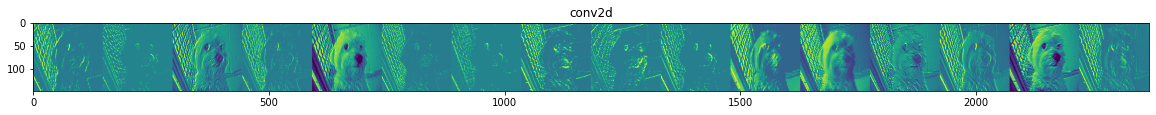

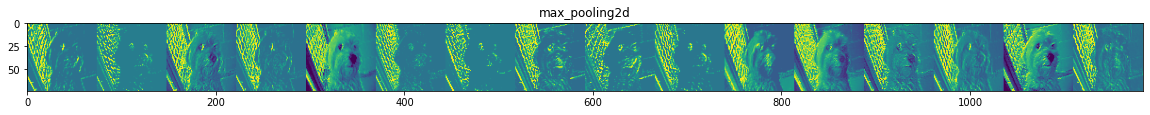

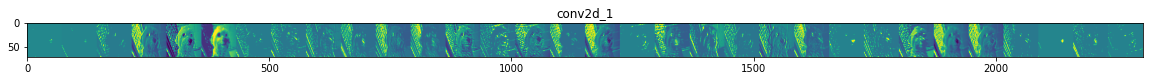

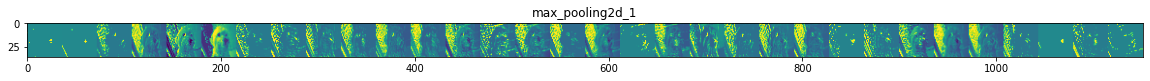

<ipython-input-58-c412fe93e18b>:24: RuntimeWarning: invalid value encountered in true_divide
  feature = (feature - feature.mean()) / feature.std()


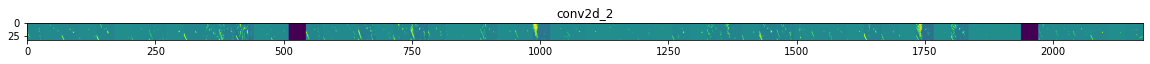

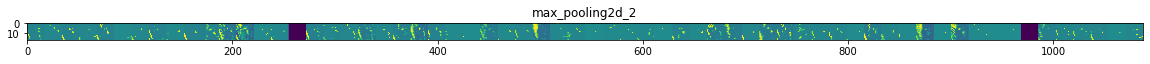

In [58]:
# Visualizing Intermediate Representations
import random

# define new model take the image as input and output the intermediat layers output.
layers_outputs = [layer.output for layer in model.layers]
layers_names = [layer.name for layer in model.layers]

# define the model with the input original model input and the output layers.
visualization_model = keras.models.Model(inputs = model.input, outputs = layers_outputs)

# feed the visualization model with an image.
features_map = visualization_model.predict(img)

# display the transformed representation of the input image.
for layer_name, feature_map in zip(layers_names, features_map):
    if len(feature_map.shape) != 4 : continue   # we care about only the conv layers.
    rows, cols, n_features = feature_map.shape[1:]
    layout = np.zeros((rows, cols*n_features))
    
    # for every feature map normalize it.
    for i in range(n_features):
        # Postprocess the feature to make it visually palatable
        feature = feature_map[0, :, :, i]
        feature = (feature - feature.mean()) / feature.std()
        feature = feature * 64 + 128
        feature = np.clip(feature, 0, 255).astype('uint8')
        layout[:, i * cols : (i + 1) * cols] = feature
        
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(layout, aspect='auto', cmap='viridis')
    plt.show()


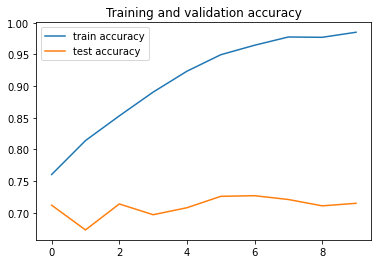

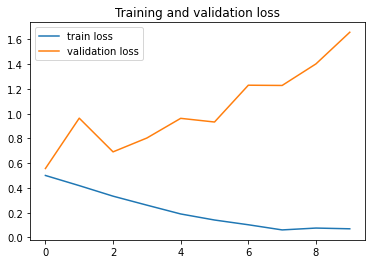

In [68]:
# Evaluating Accuracy and Loss for the Model
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label="train accuracy" )
plt.plot  ( epochs, val_acc, label="test accuracy" )
plt.title ('Training and validation accuracy')
plt.legend()
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure()
plt.plot  ( epochs,     loss, label="train loss"  )
plt.plot  ( epochs, val_loss, label="validation loss" )
plt.title ('Training and validation loss'   )
plt.legend()

In [39]:
# save the model
model_path = "models/cat_dogs_classifier_model"

# save as tensorflow savedModel format (.pb, variables, assests)
model.save(model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/cat_dogs_classifier_model/assets
